In [1]:
# pytorch
import torch
import torch.nn as nn
from torchvision.utils import make_grid
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# fastmri
import fastmri
from fastmri.data import subsample
from fastmri.data import transforms, mri_data
from fastmri.evaluate import ssim, psnr, nmse
from fastmri.losses import SSIMLoss
from fastmri.models import Unet

# other stuff
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm 
import myutils
from mymodels import VisionTransformer, ReconNet
from mymodels.vision_transformer import * # needed for loading current save models, but ugly
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
# Device
device = 'cuda'

In [2]:
class fastMRIDataset(Dataset):
    def __init__(self, isval=False):
        self.isval = isval
        if not isval:
            self.data_path = '/media/hdd1/fastMRIdata/knee/singlecoil_train/'      
        else:
            self.data_path = '/media/hdd1/fastMRIdata/knee/singlecoil_val/'

        self.data = mri_data.SliceDataset(
            root=self.data_path,
            transform=self.data_transform,
            challenge='singlecoil',
            use_dataset_cache=True,
            )

        self.mask_func = subsample.RandomMaskFunc(
            center_fractions=[0.08],
            accelerations=[4],
            )
            
    def data_transform(self, kspace, mask, target, data_attributes, filename, slice_num):
        if self.isval:
            seed = tuple(map(ord, filename))
        else:
            seed = None     
        kspace = transforms.to_tensor(kspace)
        masked_kspace, _ = transforms.apply_mask(kspace, self.mask_func, seed)        
        
        target = transforms.to_tensor(target)
        zero_fill = fastmri.ifft2c(masked_kspace)
        zero_fill = transforms.complex_center_crop(zero_fill, target.shape)   
        x = fastmri.complex_abs(zero_fill)
 

        x = x.unsqueeze(0)
        target = target.unsqueeze(0)

        return (x, target, data_attributes['max'])

    def __len__(self,):
        return len(self.data)
    
    def __getitem__(self, idx):
        data = self.data[idx]

        return data

In [3]:
# Create dataset
dataset = fastMRIDataset(isval=False)
val_dataset = fastMRIDataset(isval=True)

ntrain = 10000
train_dataset, _ = torch.utils.data.random_split(dataset, [ntrain, len(dataset)-ntrain], generator=torch.Generator().manual_seed(42))
print(len(train_dataset))

10000


In [4]:
batch_size = 1
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2,generator=torch.Generator().manual_seed(42))
valloader = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=2)  

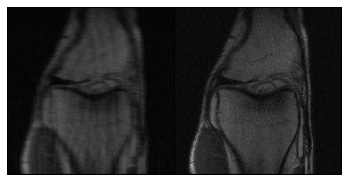

In [5]:
q = next(iter(valloader))
myutils.imshow(make_grid([q[0][0], q[1][0]], normalize = True, value_range=(0, q[2][0]/1.5)))    
plt.axis('off')
plt.show()

In [43]:
"""Init Model"""
# Vision Transformer
# avrg_img_size = 320
# patch_size = 10
# depth = 4
# num_heads = 8
# embed_dim = 44
# # gpsa_interval = [2, depth-1] # Convit
# gpsa_interval = [-1, -1] # Vanilla Vit

# net = VisionTransformer(
#     avrg_img_size=avrg_img_size, 
#     patch_size=patch_size, 
#     in_chans=1, embed_dim=embed_dim, 
#     depth=depth, num_heads=num_heads, mlp_ratio=4., 
#     gpsa_interval=gpsa_interval,
#     use_pos_embed=True, qkv_bias=False,
#     )
# Unet
# net = Unet(
#     in_chans=1,
#     out_chans=1,
#     chans=128,
#     num_pool_layers=4,
#     )

# model = ReconNet(net).to(device)

checkpoint = torch.load('/root/workspace/Models/ViT_MHSAp10_60M_knee_2k.pth')
model = checkpoint['model']
model.load_state_dict(checkpoint['model_state_dict'],)
model = model.to(device)

print('#Params:', sum(p.numel() for p in model.parameters() if p.requires_grad))
print(model)

#Params: 60408228
ReconNet(
  (net): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(1, 704, kernel_size=(10, 10), stride=(10, 10))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((704,), eps=1e-05, elementwise_affine=True)
        (attn): MHSA(
          (qkv): Linear(in_features=704, out_features=2112, bias=False)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=704, out_features=704, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((704,), eps=1e-05, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=704, out_features=2816, bias=True)
          (act): GELU()
          (fc2): Linear(in_features=2816, out_features=704, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
      (1): Block(
        (norm1): LayerNo

In [23]:
"""Qualitative Performance"""
valloader = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=0, generator=torch.Generator().manual_seed(40))
dataiter = iter(valloader)
model.eval()

with torch.no_grad():
    for k in range(0,5):    
        inputs, targets, maxval = dataiter.next()
        outputs = model(inputs.to(device)).cpu()
        inputs_ = inputs
        plt.figure(figsize=(15,7))
#         myutils.imshow(make_grid([inputs_[0], outputs[0], targets[0], (targets[0]-outputs[0]).abs()],normalize = True, value_range=(0,maxval[0]/1.5)))    
#         plt.axis('off')
#         img_input = inputs_[0].numpy()
#         img_noise = outputs[0].numpy()
#         img = targets[0].numpy()
#         print(k+1)
#         print(' ssim:', ssim(img, img_noise, maxval[0].item()))
#         print('*ssim:', ssim(img, img_input, maxval[0].item()))
#         print(' psnr:', psnr(img, img_noise, maxval[0].item()))
#         print('*psnr:', psnr(img, img_input, maxval[0].item()))
#         print(' nmse:', nmse(img, img_noise, ))
#         print('*nmse:', nmse(img, img_input))
#         plt.show()

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

In [47]:
import numpy as np
depth = 10
heads = 16
attn_dist = torch.zeros(depth, heads).to(device)
valloader = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=2, generator=torch.Generator().manual_seed(40))
dataiter = iter(valloader)
num_samples = 1000
model.eval()
with torch.no_grad():
    for j in range(0,num_samples):    
        inputs, targets, maxval = dataiter.next()
        for k in range(0, depth):
            model((inputs[0].unsqueeze(0).to(device)), k=k)
            attn_dist[k] += model.net.attention_map[0]

attn_dist /= num_samples

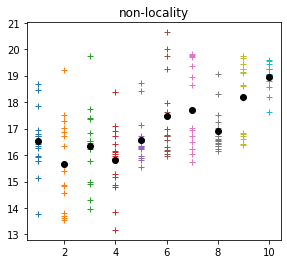

In [35]:
fig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
for i in range(0, depth):
    plt.plot((i+1)*np.ones(heads),attn_dist[i].cpu().numpy(),'+')
    plt.plot(i+1, attn_dist[i].mean().detach().cpu().numpy(),'ko')    
plt.title('non-locality')    
plt.show()

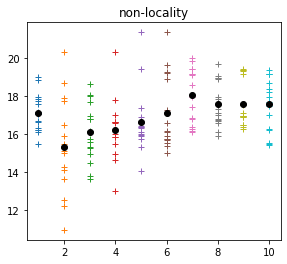

In [42]:
fig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
for i in range(0, depth):
    plt.plot((i+1)*np.ones(heads),attn_dist[i].cpu().numpy(),'+')
    plt.plot(i+1, attn_dist[i].mean().detach().cpu().numpy(),'ko')    
plt.title('non-locality')    
plt.show()

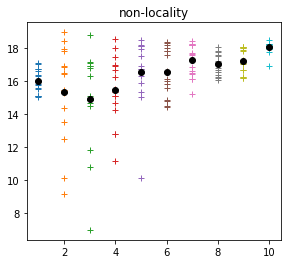

In [48]:
fig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
for i in range(0, depth):
    plt.plot((i+1)*np.ones(heads),attn_dist[i].cpu().numpy(),'+')
    plt.plot(i+1, attn_dist[i].mean().detach().cpu().numpy(),'ko')    
plt.title('non-locality')    
plt.show()

In [49]:
torch.save(attn_dist, './knee_attn_dist_60M_2k.pt')